# **FNN**
- Using data that was annotated
- Training it on the unbalanced data
- Using avgpool
- 1 second window
- Entropy is the measure of information contained in a state


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
import pygame
import time
from scipy.signal import butter, filtfilt
import random

In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/Annotated/NotAveragePooled/split_features_1s_all.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [4]:
train_data = data['train'].copy()
val_data = data['val'].copy()

In [5]:
train_data

{'melspectrogram': array([[[1.49619878e-04, 9.91906688e-07, 2.48130880e-14, ...,
          7.57408160e-14, 2.46620584e-05, 2.42136864e-04],
         [1.51059693e-04, 1.00149214e-06, 4.29179038e-14, ...,
          1.54229494e-13, 2.47809445e-05, 2.43302732e-04],
         [1.53461197e-04, 1.01720986e-06, 7.69849280e-12, ...,
          5.91120706e-12, 2.49865924e-05, 2.45357940e-04],
         ...,
         [8.10535547e-08, 1.13486703e-09, 1.55103726e-10, ...,
          9.95547819e-11, 3.92484929e-06, 3.89781243e-05],
         [6.54161468e-08, 4.35279562e-10, 1.70086070e-13, ...,
          3.73563449e-12, 3.73668669e-06, 3.71356338e-05],
         [5.58002542e-08, 3.70017484e-10, 1.19116812e-15, ...,
          8.60750760e-15, 3.62438557e-06, 3.60217485e-05]],
 
        [[2.90496083e-04, 1.33911613e-04, 1.18182281e-11, ...,
          2.01018052e-13, 9.45688580e-06, 9.98487150e-05],
         [2.97352272e-04, 1.36961177e-04, 1.73004844e-11, ...,
          3.01842594e-13, 9.68366781e-06, 1.0224

In [6]:
train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

In [7]:
val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

# Shuffle Data

In [8]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [9]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [10]:
val_y, val_features = shuffle_data(val_labels, v_features)

In [11]:
display(train_y.shape)
display(train_y[:15])

(12565,)

array([ 0, 19,  2,  1, 11, 17, 15,  2,  2,  2,  0,  1,  1, 12,  0],
      dtype=int32)

In [12]:
for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

'melspectrogram'

(12565, 60, 44)

array([[7.84775502e-07, 1.04541155e-07, 5.92184929e-14, ...,
        7.72850380e-13, 1.50455305e-06, 1.99308912e-05],
       [1.43637892e-06, 1.78491025e-07, 4.92937178e-12, ...,
        9.62104313e-13, 1.50039885e-06, 1.98801798e-05],
       [2.61793596e-06, 3.13586693e-07, 5.12367441e-10, ...,
        3.33050701e-12, 1.49344142e-06, 1.97929407e-05],
       ...,
       [1.31886477e-04, 1.82380968e-05, 2.16533206e-06, ...,
        5.73100355e-08, 5.38264920e-08, 3.54060776e-07],
       [9.46337953e-05, 1.04611567e-05, 1.51047014e-08, ...,
        7.24297314e-10, 1.10548899e-08, 1.41239396e-07],
       [8.32770139e-05, 9.19338953e-06, 7.46547140e-12, ...,
        1.72617760e-13, 4.09035900e-09, 5.30177976e-08]])

'mfcc'

(12565, 20, 44)

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00],
       [-2.56353394e-02, -4.04243039e-02, -4.93272004e-02,
        -3.99422091e-02, -6.79263003e-02, -1.96667144e-01,
        -3.23

'chroma'

(12565, 12, 44)

array([[0.45418166, 0.72417162, 0.84400895, 0.61107022, 0.16177765,
        0.08406588, 0.07871091, 0.09085746, 0.43210131, 0.4148865 ,
        0.15958238, 0.01537887, 0.00598907, 0.1234091 , 0.1805234 ,
        0.10912105, 0.37746077, 0.60944659, 0.15324954, 0.0096552 ,
        0.01103177, 0.0151817 , 0.01408949, 0.04733809, 0.22487413,
        0.37165931, 0.03097892, 0.13640315, 0.14299019, 0.05705117,
        0.09179258, 0.1364832 , 0.14358644, 0.01846696, 0.0164755 ,
        0.07741801, 0.30499387, 0.18913922, 0.14706441, 0.22446514,
        0.18165331, 0.02610124, 0.00581726, 0.00712216],
       [0.52016204, 1.        , 0.89963705, 0.5626457 , 0.04878576,
        0.01667776, 0.01785321, 0.03416596, 0.20941494, 0.26234309,
        0.33113   , 0.02036446, 0.0233444 , 0.05766761, 0.06015926,
        0.0397873 , 0.11189695, 0.17879961, 0.09591941, 0.00821891,
        0.01142575, 0.03209377, 0.04385042, 0.062673  , 0.17965656,
        0.55776516, 0.0834372 , 0.08105305, 0.07019021, 0.0

'rms'

(12565, 1, 44)

array([[0.00042678, 0.00059195, 0.00066221, 0.00266672, 0.01894865,
        0.05044331, 0.059994  , 0.06361411, 0.06080426, 0.03890417,
        0.02159314, 0.00412699, 0.00828255, 0.04821568, 0.0552038 ,
        0.06168093, 0.06127792, 0.03874452, 0.02785926, 0.00407735,
        0.00377954, 0.00320123, 0.00225214, 0.00160779, 0.00071549,
        0.0005343 , 0.00279343, 0.04182558, 0.05554684, 0.06510469,
        0.06509288, 0.04996798, 0.03417933, 0.00437773, 0.0081867 ,
        0.04297466, 0.05954576, 0.06740137, 0.06705415, 0.0521164 ,
        0.03182307, 0.00401865, 0.00298731, 0.00281208]], dtype=float32)

In [13]:
display(val_y.shape)
display(val_y[:15])

(3318,)

array([ 3,  2,  1,  0,  0,  8, 19,  2, 19,  5, 19, 15, 11,  7,  2],
      dtype=int32)

In [14]:
for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

'melspectrogram'

(3318, 60, 44)

array([[6.42724926e-03, 1.61590706e-03, 1.85316100e-11, ...,
        4.40824721e-15, 8.08388175e-08, 1.20024688e-06],
       [6.50865056e-03, 1.63640938e-03, 2.17210829e-11, ...,
        6.28241305e-14, 1.30052649e-07, 2.05712216e-06],
       [6.65039460e-03, 1.67213541e-03, 2.86126618e-11, ...,
        2.88344201e-12, 2.17658389e-07, 3.58838522e-06],
       ...,
       [3.79743806e-05, 9.60485804e-06, 1.64506789e-07, ...,
        4.60614745e-06, 1.27228406e-05, 6.08483868e-05],
       [4.74401400e-05, 1.19335140e-05, 8.10852754e-11, ...,
        4.05283506e-09, 1.90903630e-06, 3.31064861e-05],
       [5.14075068e-05, 1.29323083e-05, 5.56615965e-14, ...,
        6.62913772e-13, 1.61591842e-06, 2.81746279e-05]])

'mfcc'

(3318, 20, 44)

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00],
       [ 3.69082121e-01,  2.06131490e-01, -1.67755656e-01,
        -1.68608650e-01, -1.50712376e-01, -1.13542411e-01,
        -9.15

'chroma'

(3318, 12, 44)

array([[9.42899955e-03, 3.27749184e-03, 1.08175497e-04, 1.45858043e-04,
        1.10794916e-03, 1.27260204e-02, 2.05268047e-02, 2.46439307e-02,
        1.20426530e-03, 1.16500621e-04, 5.00805081e-05, 1.09377162e-04,
        1.51730455e-03, 1.47828180e-02, 1.79741874e-02, 2.37671269e-02,
        2.70650754e-02, 2.87400447e-02, 2.46841101e-02, 1.88470322e-02,
        1.15084797e-02, 1.28619765e-02, 6.31884842e-03, 1.66974941e-02,
        4.70158425e-02, 5.48145527e-02, 1.02565879e-01, 1.30928731e-01,
        9.33772876e-02, 4.13324537e-02, 4.22321916e-02, 4.55412256e-02,
        5.54347715e-02, 6.18774020e-02, 4.14449824e-03, 3.07048748e-04,
        1.06247045e-04, 4.01873363e-05, 2.72319291e-05, 1.23918432e-04,
        6.24744615e-04, 3.83183399e-03, 6.09341485e-03, 1.21635272e-02],
       [9.57672254e-03, 3.30259851e-03, 6.34091626e-05, 1.41498633e-04,
        7.95151108e-04, 8.54180092e-03, 1.07837227e-02, 1.22348047e-02,
        6.82225227e-04, 5.53304479e-05, 1.83735676e-05, 6.97767

'rms'

(3318, 1, 44)

array([[0.10727371, 0.11723097, 0.11885495, 0.07677956, 0.0517102 ,
        0.02134868, 0.00932608, 0.01449443, 0.06171579, 0.08628458,
        0.08827559, 0.08767469, 0.06393526, 0.0211967 , 0.01009882,
        0.00818585, 0.00683696, 0.0061904 , 0.00674727, 0.00696326,
        0.00741868, 0.00873187, 0.00814964, 0.00772938, 0.00709669,
        0.00517025, 0.00431905, 0.00405049, 0.00403852, 0.00402221,
        0.00417624, 0.00419654, 0.00425881, 0.00584312, 0.04064162,
        0.07025695, 0.11470162, 0.12479409, 0.12018701, 0.1059524 ,
        0.0551225 , 0.02478349, 0.01100257, 0.00719993]], dtype=float32)

## **FNN Model**

In [15]:
train_results = {}
val_results = {}

In [16]:
def build_model(input_features,
                hidden_layers=[256, 64, 64],
                learning_rate=0.00005,
                output_units=20,
                dropout_rate=0.4):

  tf.keras.backend.clear_session()

  # set input layer
  input = tf.keras.Input(shape=(input_features,), name='Input')

  # set hidden layers
  hidden_output = input

  for i, hidden_dim in enumerate(hidden_layers):
    hidden_output = tf.keras.layers.Dense(units=hidden_dim,
                                          activation='relu',
                                          name=f'hidden{i}')(hidden_output)
    # hidden_output = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout{i}')(hidden_output)

  # set output layer
  output = tf.keras.layers.Dense(units=output_units,
                                 activation='softmax',
                                 name='Output')(hidden_output)
  # create model
  model = tf.keras.models.Model(inputs=input, outputs=[output])

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [17]:
def visualize(model_history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

### **With all the features**

In [18]:
training_features_3D = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['rms'], train_features['melspectrogram']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(12565, 4092)

In [19]:
validation_features_3D = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['rms'], val_features['melspectrogram']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(3318, 4092)

Fit the model with training data

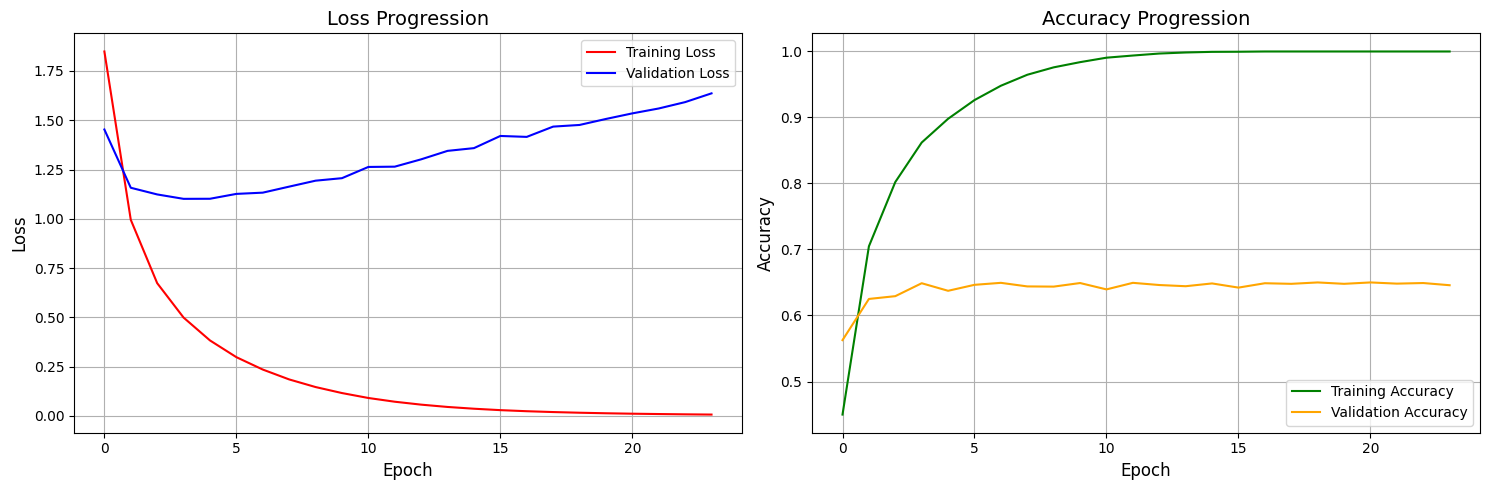

In [22]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/Annotated/AveragePooled/1s_all_features_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=64,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [23]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8971 - loss: 0.4002
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6516 - loss: 1.0918


### **With MFCCs only**

In [24]:
training_features_3D = train_features['mfcc']
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(12565, 880)

In [27]:
validation_features_3D = val_features['mfcc']
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(3318, 880)

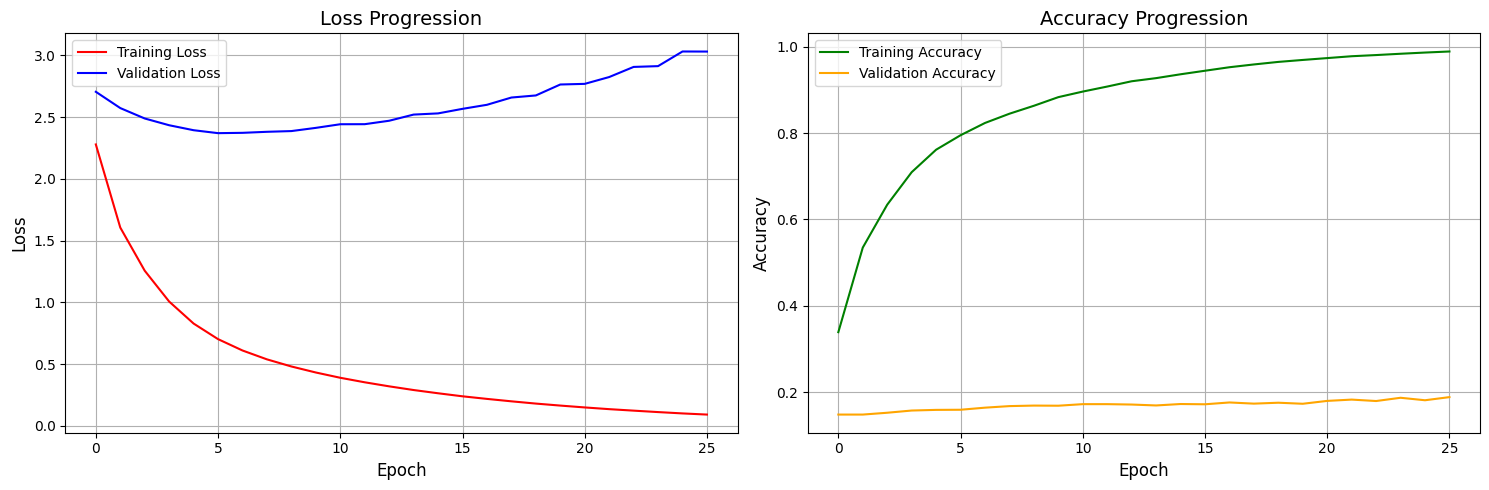

In [28]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/Annotated/AveragePooled/1s_all_features_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=64,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [29]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8178 - loss: 0.6388
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1543 - loss: 2.3660


## **With MFCCs and Mel-Spectrogram**

In [30]:
training_features_3D = np.concatenate((train_features['mfcc'], train_features['melspectrogram']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(12565, 3520)

In [31]:
validation_features_3D = np.concatenate((val_features['mfcc'], val_features['melspectrogram']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(3318, 3520)

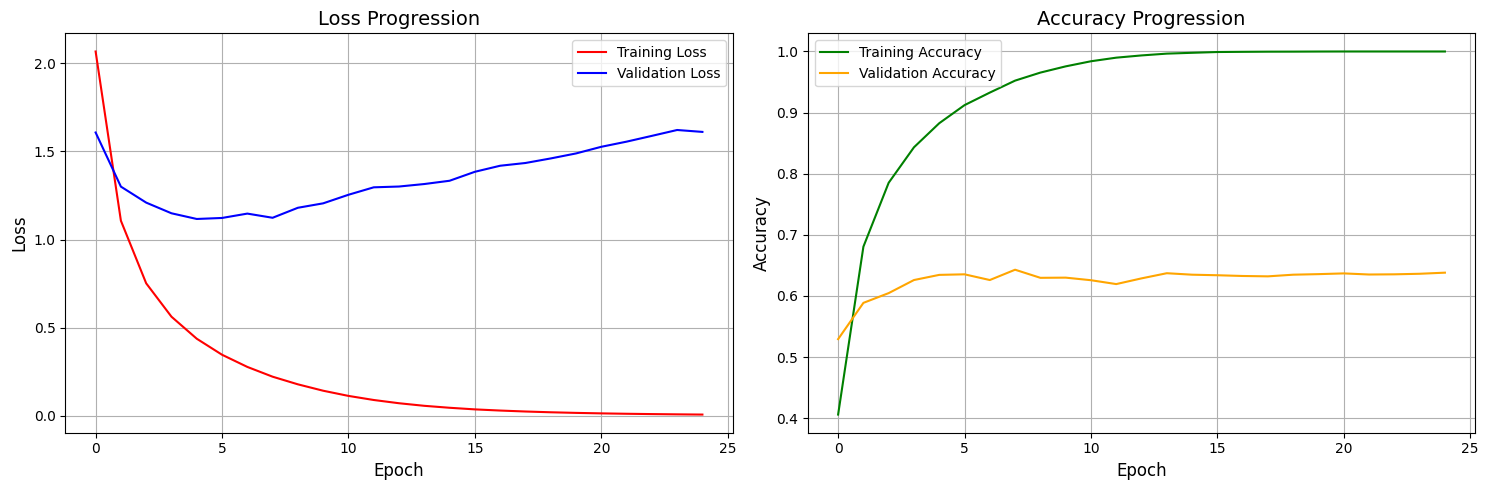

In [32]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/Annotated/AveragePooled/1s_all_features_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=64,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [33]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9136 - loss: 0.3554
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6438 - loss: 1.1126


## **With MFCCs and Chroma**

In [34]:
training_features_3D = np.concatenate((train_features['mfcc'], train_features['chroma']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(12565, 1408)

In [35]:
validation_features_3D = np.concatenate((val_features['mfcc'], val_features['chroma']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(3318, 1408)

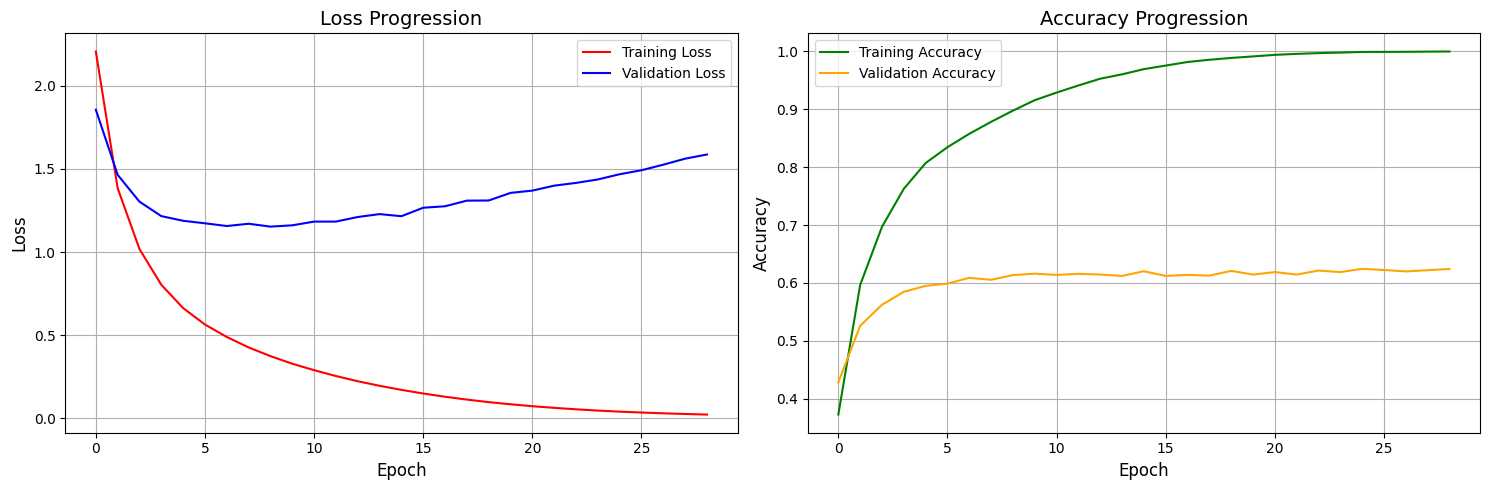

In [36]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/Annotated/AveragePooled/1s_all_features_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=64,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [37]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9133 - loss: 0.3335
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6214 - loss: 1.1421


## **With MFCCs and RMS**

In [38]:
training_features_3D = np.concatenate((train_features['mfcc'], train_features['rms']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(12565, 924)

In [39]:
validation_features_3D = np.concatenate((val_features['mfcc'], val_features['rms']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(3318, 924)

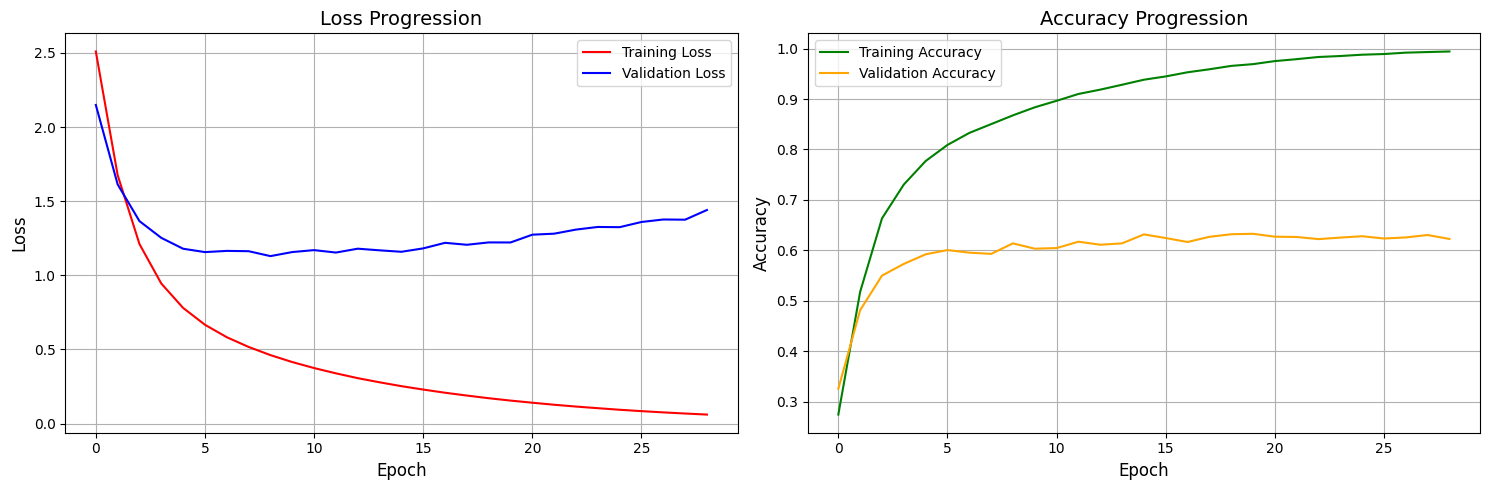

In [40]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/Annotated/AveragePooled/1s_all_features_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=64,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [41]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8822 - loss: 0.4234
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6133 - loss: 1.1323


## **With Mel-Spectrogram, MFCCs, RMS**

In [42]:
training_features_3D = np.concatenate((train_features['melspectrogram'], train_features['rms'], train_features['mfcc']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(12565, 3564)

In [43]:
validation_features_3D = np.concatenate((val_features['melspectrogram'], val_features['rms'], val_features['mfcc']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(3318, 3564)

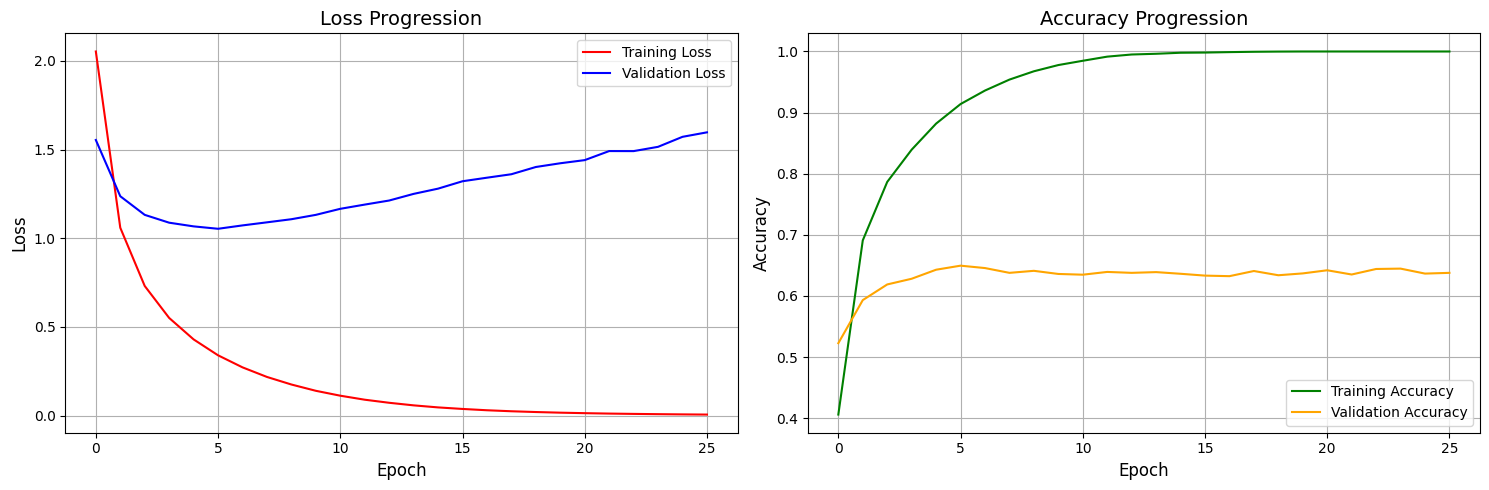

In [44]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/Annotated/AveragePooled/1s_all_features_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=64,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [45]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9405 - loss: 0.2780
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6668 - loss: 1.0281


## **With Mel-Spectrogram, MFCCs, Chroma**

In [46]:
training_features_3D = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_features['mfcc']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(12565, 4048)

In [47]:
validation_features_3D = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_features['mfcc']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(3318, 4048)

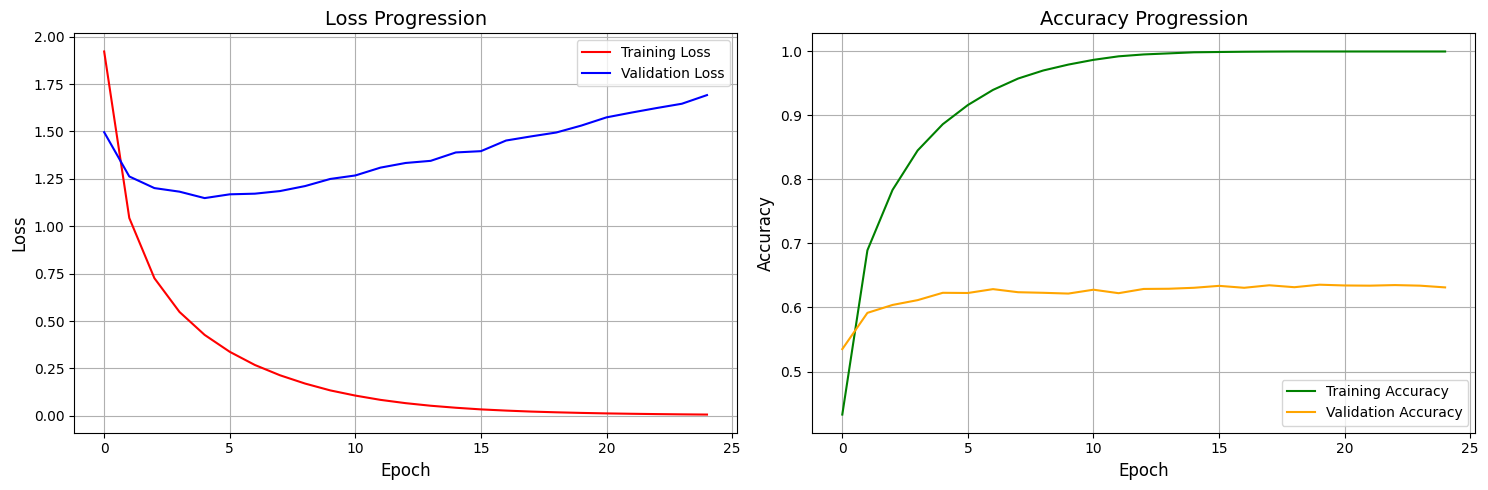

In [48]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/Annotated/AveragePooled/1s_all_features_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=64,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [49]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9180 - loss: 0.3437
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6272 - loss: 1.1263


# Review results from all models

In [50]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.919,0.623
